**Data Collection & Preprocessing**

In [29]:
import ccxt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Fetch data
def fetch_data(symbol='BTC/USDT', timeframe='1d', limit=5000):
    exchange = ccxt.binance()
    data = exchange.fetch_ohlcv(symbol, timeframe, limit=limit)
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('date', inplace=True)
    df.drop('timestamp', axis=1, inplace=True)
    return df

# Preprocessing
def preprocess_data(df):
    # General scaler
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    
    # Close scaler
    close_scaler = MinMaxScaler()
    df['close'] = close_scaler.fit_transform(df[['close']])
    
    df = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)
    return df, scaler, close_scaler

**Feature Engineering**

In [30]:
import talib

def add_technical_indicators(df):
    df['SMA'] = talib.SMA(df['close'], timeperiod=14)
    df['RSI'] = talib.RSI(df['close'], timeperiod=14)
    df['MACD'], df['MACD_signal'], _ = talib.MACD(df['close'])
    df.dropna(inplace=True)
    return df


**LSTM Model Design**

In [31]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

**Training Data Preparation**

In [32]:
def create_sequences(data, sequence_length):
    x, y = [], []
    data_values = data.values  # Convert dataframe to numpy array
    for i in range(len(data_values) - sequence_length):
        x.append(data_values[i:i+sequence_length])
        y.append(data_values[i+sequence_length, 3])  # Assuming 'close' prices are at index 3
    return np.array(x), np.array(y)

**Execution**

In [33]:
import numpy as np

# Fetch, preprocess and add features
df = fetch_data()
train, scaler, close_scaler = preprocess_data(train)
df = add_technical_indicators(df)

# Splitting data (let's say last 100 rows as test set)
train = df[:-100]
test = df[-100:]

# Create sequences
sequence_length = 60
x_train, y_train = create_sequences(train, sequence_length)
x_test, y_test = create_sequences(test, sequence_length)

# Build and train the model
model = build_model((x_train.shape[1], x_train.shape[2]))
model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
26/26 [==============================] - 4s 59ms/step - loss: 1265975424.0000 - val_loss: 793496768.0000
Epoch 2/50
26/26 [==============================] - 1s 26ms/step - loss: 1265074048.0000 - val_loss: 792577728.0000
Epoch 3/50
26/26 [==============================] - 1s 27ms/step - loss: 1263913856.0000 - val_loss: 791526784.0000
Epoch 4/50
26/26 [==============================] - 1s 28ms/step - loss: 1262580480.0000 - val_loss: 790318144.0000
Epoch 5/50
26/26 [==============================] - 1s 27ms/step - loss: 1261018496.0000 - val_loss: 788855168.0000
Epoch 6/50
26/26 [==============================] - 1s 27ms/step - loss: 1259155328.0000 - val_loss: 787186816.0000
Epoch 7/50
26/26 [==============================] - 1s 26ms/step - loss: 1257069824.0000 - val_loss: 785309504.0000
Epoch 8/50
26/26 [==============================] - 1s 27ms/step - loss: 1254717312.0000 - val_loss: 783202816.0000
Epoch 9/50
26/26 [==============================] - 1s 27ms/step - loss:

**Visualize**

2/2 [==============================] - 1s 8ms/step


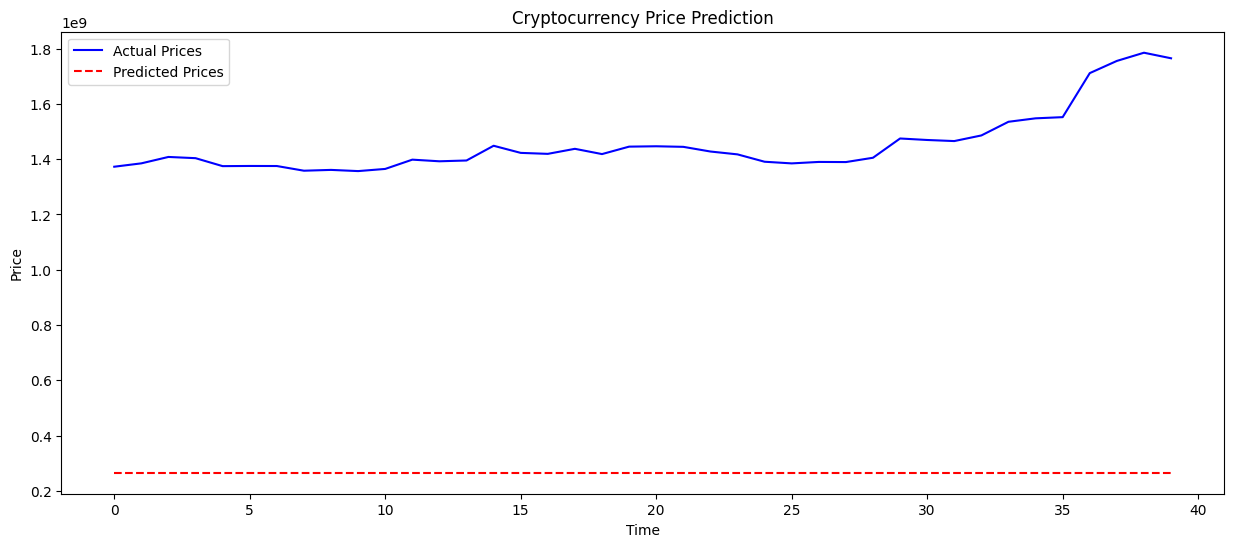

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Get predictions
predictions = model.predict(x_test)

# Inverse transform the predictions and actual values to original scale
predicted_prices = close_scaler.inverse_transform(predictions)
actual_prices = close_scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(actual_prices, color='blue', label='Actual Prices')
plt.plot(predicted_prices, color='red', linestyle='dashed', label='Predicted Prices')
plt.title('Cryptocurrency Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()